In [45]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline
import matplotlib.pyplot as plt

# Return Forecasting: Historical Daily Yen Futures Data

Time Series Analysis on Historical Dollar-Yen exchange rate futures data to determine whether there is any predictable behavior.

In [2]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("data/yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [3]:
# Triming the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


 # Return Forecasting: Initial Time-Series Plotting

Plotting the "Settle" price to see any patterns, long-term and/or short.

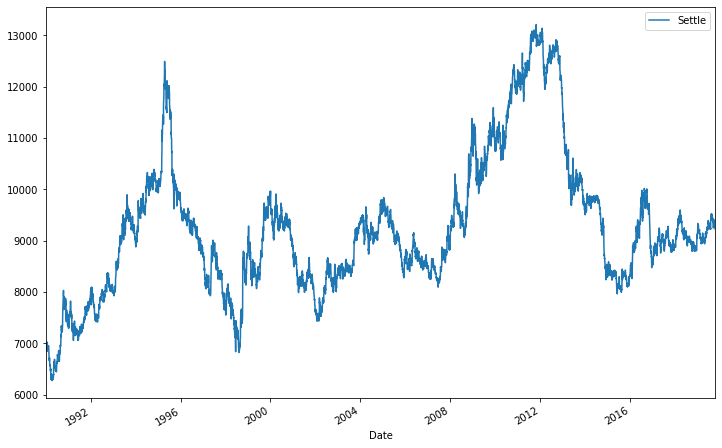

In [14]:
# Plotting just the "Settle" column from the dataframe:
yen_futures.plot(y='Settle',figsize=(12,8))

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter to decompose the Settle price into a trend and noise.

In [31]:
import statsmodels.api as sm

# Applying the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:
noise,trend = sm.tsa.filters.hpfilter(yen_futures['Settle'])

In [1]:
# Creating a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:

In [41]:
noise_df = pd.DataFrame(noise)
trend_df = pd.DataFrame(trend)
noise_df.rename(columns={"Settle": "noise"},inplace=True)
trend_df.rename(columns={"Settle": "trend"},inplace=True)
noise_df.head()

,noise
Date,
1990-01-02,-61.503967
1990-01-03,-21.799756
1990-01-04,98.942896
1990-01-05,40.776052
1990-01-08,49.689938


In [43]:
settle_price = pd.concat([yen_futures['Settle'], noise_df,trend_df], axis=1, sort=False)
settle_price.head()

,Settle,noise,trend
Date,,,
1990-01-02,6847.0,-61.503967,6908.503967
1990-01-03,6887.0,-21.799756,6908.799756
1990-01-04,7008.0,98.942896,6909.057104
1990-01-05,6950.0,40.776052,6909.223948
1990-01-08,6959.0,49.689938,6909.310062


In [2]:
# Plotting the Settle Price vs. the Trend

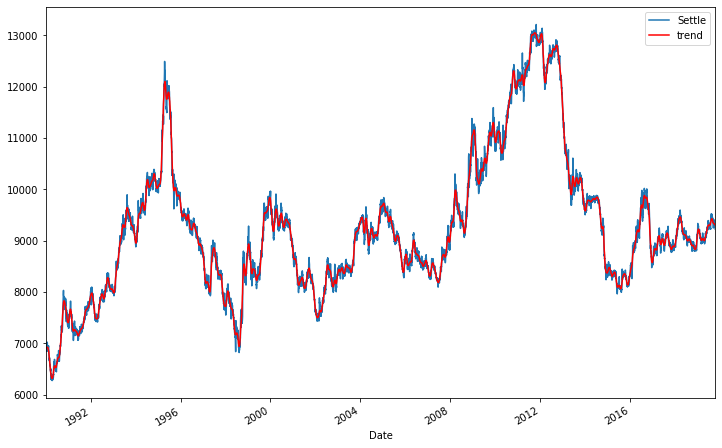

In [48]:
ax = plt.gca()
settle_price.plot(kind='line',y='Settle',figsize=(12,8),ax=ax)
settle_price.plot(kind='line',y='trend', color='red',ax=ax)
plt.show()

Smoothing with the HP Filter and plotting the resulting trend against the actual futures returns, we can see that there's a lot of short term fluctuations that deviate around this trend. Perhaps these would represent profitable trading opportunities: For example, when the blue line deviates far below the orange, we can see this as a sign that the Yen is temporarily more undervalued than it should be (and, therefore, we'd see this as a short-term buying opportunity).

In [3]:
# Plot of the Settle Noise


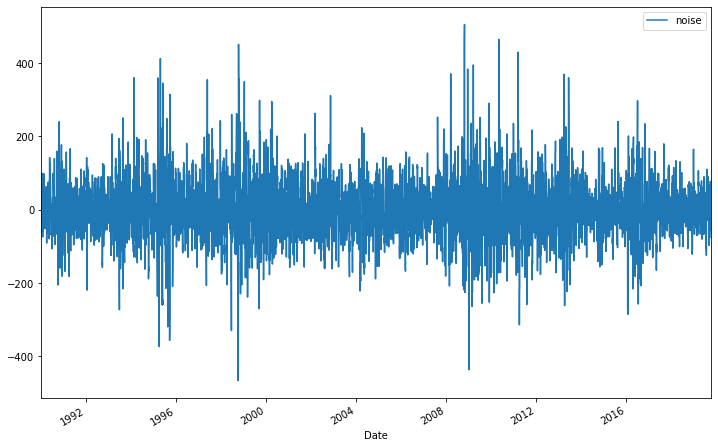

In [50]:
settle_price.plot(kind='line',y='noise',figsize=(12,8))

---

# Forecasting Returns using an ARMA Model

In [51]:
# Creating a series using "Settle" price percentage returns, dropping any nan"s, and checking the results:
# replacing inf, -inf values with np.nan"s
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Settle
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


In [54]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
# Estimating and ARMA model using statsmodels (use order=(2, 1))
model = ARMA(returns.values, order=(2,1))

# Fitting the model and assign it to a variable called results
results = model.fit()

In [56]:
# Outputing model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7514
Model:                     ARMA(2, 1)   Log Likelihood               -7894.071
Method:                       css-mle   S.D. of innovations              0.692
Date:                Mon, 04 Nov 2019   AIC                          15798.142
Time:                        17:25:19   BIC                          15832.765
Sample:                             0   HQIC                         15810.030
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0063      0.008      0.804      0.422      -0.009       0.022
ar.L1.y       -0.3061      1.278     -0.240      0.811      -2.810       2.198
ar.L2.y       -0.0019      0.019     -0.099      0.921      -0.040       0.036
ma.L1.y        0.2945      1.278      0.231      0.818      -2.209       2.799
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.3362           +0.0000j            3.3362            0.5000
AR.2         -157.2091           +0.0000j          157.2091            0.5000
MA.1           -3.3952           +0.0000j            3.3952            0.5000
-----------------------------------------------------------------------------
"""

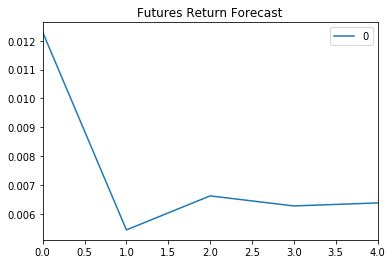

In [59]:
# Plotting the 5 Day Returns Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="Futures Return Forecast")

---

# Forecasting the Settle Price using an ARIMA Model

In [60]:
from statsmodels.tsa.arima_model import ARIMA

# Estimating and ARIMA Model:
# ARIMA(df, order=(p, d, q))
model = ARIMA(settle_price['Settle'], order=(5, 1, 1))

# Fitting the model
results = model.fit()

/Users/carlosysmayelalvarez/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/carlosysmayelalvarez/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [66]:
# Outputing model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Settle   No. Observations:                 7514
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -41944.619
Method:                       css-mle   S.D. of innovations             64.281
Date:                Mon, 04 Nov 2019   AIC                          83905.238
Time:                        18:33:01   BIC                          83960.635
Sample:                             1   HQIC                         83924.259
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.3162      0.700      0.452      0.651      -1.056       1.688
ar.L1.D.Settle     0.2824      0.699      0.404      0.686      -1.088       1.652
ar.L2.D.Settle     0.0007      0.016      0.043      0.966      -0.030       0.032
ar.L3.D.Settle    -0.0126      0.012     -1.032      0.302      -0.037       0.011
ar.L4.D.Settle    -0.0137      0.015     -0.889      0.374      -0.044       0.016
ar.L5.D.Settle    -0.0011      0.018     -0.064      0.949      -0.036       0.034
ma.L1.D.Settle    -0.2975      0.699     -0.426      0.670      -1.667       1.072
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8921           -1.3784j            2.3409           -0.1002
AR.2            1.8921           +1.3784j            2.3409            0.1002
AR.3           -2.2714           -3.0198j            3.7787           -0.3526
AR.4           -2.2714           +3.0198j            3.7787            0.3526
AR.5          -11.1143           -0.0000j           11.1143           -0.5000
MA.1            3.3618           +0.0000j            3.3618            0.0000
-----------------------------------------------------------------------------
"""

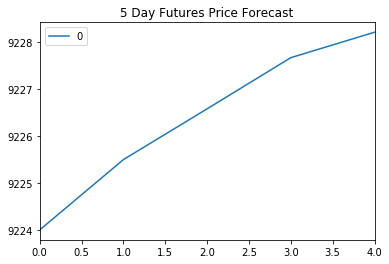

In [64]:
# Plotting the 5 Day Price Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 Day Futures Price Forecast")

---

In [69]:
import arch as arch
from arch import arch_model

In [70]:
# Estimating a GARCH model:
model = arch_model(returns, mean="Zero", vol="GARCH", p=2, q=1)

# Fitting the model
res = model.fit(disp="off")

/Users/carlosysmayelalvarez/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.4787. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)


In [72]:
# Summarizing the model results
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7461.93
Distribution:                  Normal   AIC:                           14931.9
Method:            Maximum Likelihood   BIC:                           14959.6
                                        No. Observations:                 7514
Date:                Mon, Nov 04 2019   Df Residuals:                     7510
Time:                        18:36:12   Df Model:                            4
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      4.2896e-03  2.057e-03      2.085  3.708e-02  [2.571e-04,8.322e-03]
alpha[1]       0.0381  1.282e-02      2.970  2.974e-03  [1.295e-02,6.321e-02]
alpha[2]       0.0000  1.703e-02      0.000      1.000 [-3.338e-02,3.338e-02]
beta[1]        0.9536  1.420e-02     67.135      0.000      [  0.926,  0.981]
=============================================================================

Covariance estimator: robust
"""

In [73]:
# Finding the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

In [74]:
# Creating a 5 day forecast of volatility
forecast_horizon = 5
# Starting the forecast using the last_day calculated above
forecasts = res.forecast(start='2019-10-15', horizon=forecast_horizon)
forecasts

In [75]:
# Annualizing the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-10-15,7.434048,7.475745,7.516867,7.557426,7.597434


In [76]:
# Transposing the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2019-10-15
h.1,7.434048
h.2,7.475745
h.3,7.516867
h.4,7.557426
h.5,7.597434


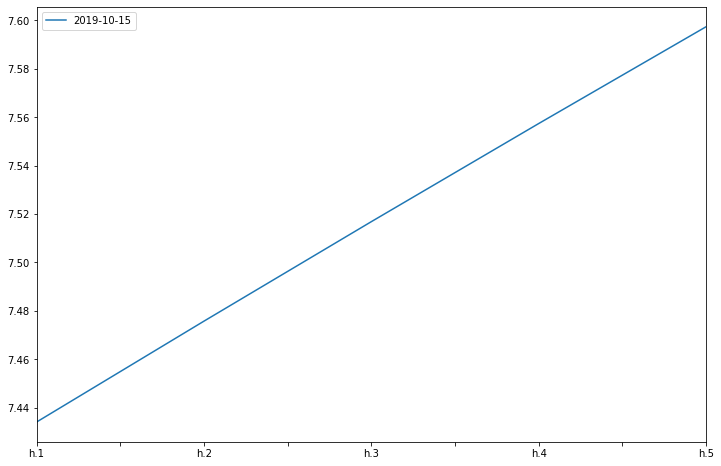

In [78]:
# Plotting the final forecast
final.plot(kind='line',y='2019-10-15',figsize=(12,8))

---

# Conclusions

Based on the time series analysis I would buy the yen, for a 5 day forecasting the price of the yen is predicted to grow.

According to the GARCH volatility forecasting the risk of the yen is expected to increase when we see values calculated for our forecast horizon. 

Since for both ARMA and ARIMA models the P>|z| values are way bigger than 0.05, the predictions could have been generated by a random process, in wich case I wouldn't recommend making a decision of whether to buy or not yens based on the forecasting of this models.